In [1]:
import os
import time
import torch

import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat

from sparsecoding.preprocess import patch_images, preprocess_images
from sparsecoding import inference

from sparsecoding.visualization import plot_dictionary

/Users/christianshewmake/Desktop/projects/mlenv/lib/python3.9/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")


### Define constants and load data

In [2]:
# your path here
img_dir = os.path.join(os.environ['DATA_PATH'],'data','IMAGES.mat')
# img_dir = os.path.join(os.environ['DATA_PATH'],'IMAGES.mat')

images = loadmat(img_dir)['IMAGES']
images = torch.tensor(images)
print(images.shape)

torch.Size([512, 512, 10])


In [3]:
n_images = images.shape[-1]
n_divisions = 32

image_data, n_images, n_divisions, patch_size_x, patch_size_y = patch_images(images, n_divisions=n_divisions)
data = preprocess_images(image_data, patch_size_x, patch_size_y)

### Visualize patches

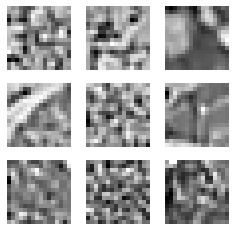

In [4]:
figure = plt.figure(figsize=(4,4))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(data), size=(1,)).item()
    img = (data[sample_idx])
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.imshow(img.squeeze().reshape([patch_size_x,patch_size_y]), cmap="gray")
plt.show()

### Inference Demo | Given a dictionary and a dataset

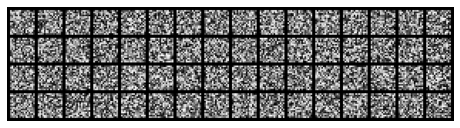

In [5]:
# Define random dictionary
n_samples, n_features = data.shape
n_basis = 16*4
n_features = patch_size_x**2
dictionary = 2*torch.rand([n_features,n_basis]) - 1

nrow = 16
fig,ax = plot_dictionary(dictionary,nrow=nrow,size=8)

In [6]:
# The Locally Competitive Algorithm
lca = inference.LCA(coeff_lr=1e-3,threshold=0.1,n_iter=300)
A = lca.infer(data[:,:],dictionary)

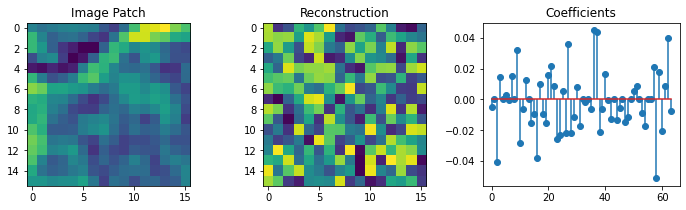

In [7]:
fig,(ax1,ax2,ax3)=  plt.subplots(figsize=(12,3),nrows=1, ncols=3)
ax1.imshow(data[0,:].detach().reshape(patch_size_x,patch_size_x))
ax1.set_title('Image Patch')

ax2.imshow(dictionary[:,0].detach().reshape(patch_size_x,patch_size_x))
ax2.set_title('Reconstruction')

ax3.stem(A[2,:].reshape(-1))
ax3.set_title('Coefficients')
plt.show()